In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
import datetime as dt
import copy

pd.options.mode.chained_assignment = None  # default='warn'

In [212]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn import svm

## 1. Data Cleaning and Feature Engineering

#### 1.1 First clean: only take the useful columns

In [230]:
round4 = pd.read_json("round4_merged.json")
round3 = pd.read_json("round3_merged.json")
round2 = pd.read_json("round2_merged.json")
round1 = pd.read_json("round1_merged.json")
sent_info = pd.read_json("sent_info.json")

In [231]:
round4_clean = round4[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount", "percent_agreed",
                       "calendars", "price_requested", "beds", "number_of_reviews"]]
round3_clean = round3[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested", "beds", "number_of_reviews"]]
round2_clean = round2[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested", "beds", "number_of_reviews"]]
round1_clean = round1[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "availability", "price", "discount",
                       "calendars", "price_requested", "beds", "number_of_reviews"]]

print "Number of observations in round 4: ", len(round4_clean)
print "Number of observations in round 3: ", len(round3_clean)
print "Number of observations in round 2: ", len(round2_clean)
print "Number of observations in round 1: ", len(round1_clean)

# round3_clean.reset_index(drop=True).head()

Number of observations in round 4:  281
Number of observations in round 3:  288
Number of observations in round 2:  226
Number of observations in round 1:  194


In [232]:
round1_clean = round1_clean.rename(columns = {"availability":"decision", "price":"price_agreed", "discount":"percent_agreed"})
round4_clean = round4_clean.rename(columns = {"discount":"discount_agreed"})

round1_clean["percent_agreed"] = [np.nan if val==None else float(val.strip("%"))/100. for val in  round1_clean.percent_agreed.values]

combined = pd.concat([round1_clean, round2_clean, round3_clean, round4_clean], keys=["round1", "round2", "round3", "round4"], ignore_index=False)
combined["source"] = combined.index.labels[0]+1
combined = combined.reset_index(drop=True)

In [233]:
sent_info = sent_info.rename(columns = {"property_id":"id"})
sent_info_clean = sent_info[['id', 'source', 'start', 'end', 'sent_date']]

In [234]:
sent_info_clean.head()

,id,source,start,end,sent_date
0,8823897,1,2016-03-31,2016-04-01,2016-03-28
1,7803063,1,2016-04-02,2016-04-03,2016-03-28
10,9505762,1,2016-03-27,2016-03-28,2016-03-28
100,3676461,1,2016-04-01,2016-04-03,2016-03-28
1000,2738669,1,2016-05-06,2016-05-09,2016-03-28


In [235]:
combined.head()

,beds,bucket_name,calendars,decision,discount_agreed,discount_asked,host_acceptance_rate,host_id,host_response_rate,host_total_listings_count,id,instant_bookable,nightly_price,number_of_reviews,percent_agreed,price_agreed,price_requested,room_type,source
0,1,daysM_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",0,NaN,0.7,100%,28811542,100%,1,5557381,t,51,41,NaN,NaN,35,Private room,1
1,1,days1_weeksM,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",-1,NaN,0.7,100%,403032,100%,1,9147025,f,134,3,NaN,NaN,90,Entire home/apt,1
2,1,days3_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",-1,NaN,0.9,100%,1172202,100%,5,2745620,t,41,41,NaN,NaN,35,Private room,1
3,2,days2_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",-1,NaN,0.7,92%,38964485,100%,2,7879486,f,101,15,NaN,NaN,70,Entire home/apt,1
4,1,daysM_weeks2,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",0,NaN,0.6,None,1594959,100%,1,3557570,f,65,22,NaN,NaN,35,Private room,1


In [236]:
combined = pd.merge(combined, sent_info_clean, on=['id', 'source'], how='inner')

In [237]:
combined.isnull().sum()

beds                            0
bucket_name                     0
calendars                       0
decision                        0
discount_agreed               999
discount_asked                  0
host_acceptance_rate           77
host_id                         0
host_response_rate             27
host_total_listings_count       0
id                              0
instant_bookable                0
nightly_price                   0
number_of_reviews               0
percent_agreed               1002
price_agreed                  822
price_requested               283
room_type                       0
source                          0
start                           0
end                             0
sent_date                       0
dtype: int64

#### 1.2 Add useful independent variables

Add variables from the calendars:
* median price
* standard deviation （normalized, using the median price)

In [238]:
calendar_price =  np.array([(np.median(calendar["price_USD"].values()), np.std(calendar["price_USD"].values()), np.max(calendar["price_USD"].values())) 
                            for calendar in combined["calendars"].values])
calendar_median_price = calendar_price[:,0]
calendar_price_std = calendar_price[:,1]
calendar_price_high = calendar_price[:,2]

combined["price_median"]=calendar_median_price
combined["price_std"]=calendar_price_std/calendar_median_price
combined["orig_percent_off"]=1-combined["nightly_price"]/calendar_price_high

* 1-month occupancy rate

In [239]:
key_1m = map(str, range(30))
calendar_occupancy = [np.mean([calendar["availability"][key] for key in key_1m]) for calendar in combined["calendars"].values]

combined["occupancy_1m"]=calendar_occupancy

Convert string variables to numeric:
* whether room will be shared
* whether instant booking is turned on
* the response rate of the host (contains nans)

In [240]:
shared = combined["room_type"].values
combined["shared"] = [x!="Entire home/apt" for x in shared]
# shared_binary

instant = combined["instant_bookable"].values
combined["instant"] = [x=="t" for x in shared]
# instant_binary

In [241]:
response_imputer = Imputer(copy=True, missing_values='NaN', strategy='mean', axis=1)
response_num = np.array([float(response_rate.strip('%'))/100 for response_rate in combined["host_response_rate"].fillna(value="-100%").values])
response_num = np.array([np.nan if x < 0 else x for x in response_num])
# response_imputer.fit(response_num)
response_imputed = response_imputer.fit_transform(response_num)[0]

# print len(response_imputed)
combined["response_rate"] = response_imputed

/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


#### 1.3 Add indicators for the buckets

Continuous:
* length_num
* advance_num

Categorical:
* orphan
* orp_1
* orp_2
* orp_3

In [242]:
# calc_len = lambda row: (dt.datetime.strptime(row["end"], '%Y-%m-%d') - dt.datetime.strptime(row["start"], '%Y-%m-%d')).days
calc_len = lambda row: (dt.datetime.strptime(row["end"], '%Y-%m-%d') - dt.datetime.strptime(row["start"], '%Y-%m-%d')).days
calc_adv = lambda row: np.floor((dt.datetime.strptime(row["start"], '%Y-%m-%d') - dt.datetime.strptime(row["sent_date"], '%Y-%m-%d')).days/7)

In [243]:
combined["length_num"] = combined.apply(calc_len, axis=1)
combined["advance_num"] = combined.apply(calc_adv, axis=1)

In [244]:
opening_attr = combined["bucket_name"].values
# orphan = []
# advance = []
N = len(opening_attr)
orp_1 = np.zeros(N)
orp_2 = np.zeros(N)
orp_3 = np.zeros(N)
adv_1 = np.zeros(N)
adv_2 = np.zeros(N)

orphan = np.ones(N)

for (i,x) in enumerate(opening_attr):
    if x == "days1_weeks1":
        orp_1[i] = 1
        adv_1[i] = 1
    elif x == "days1_weeks2":
        orp_1[i] = 1
        adv_2[i] = 1
    elif x == "days1_weeksM":
        orp_1[i] = 1
    elif x == "days2_weeks1":
        orp_2[i] = 1
        adv_1[i] = 1
    elif x == "days2_weeks2":
        orp_2[i] = 1
        adv_2[i] = 1
    elif x == "days2_weeksM":
        orp_2[i] = 1
    elif x == "days3_weeks1":
        orp_3[i] = 1
        adv_1[i] = 1
    elif x == "days3_weeks2":
        orp_3[i] = 1
        adv_2[i] = 1
    elif x == "days3_weeksM":
        orp_3[i] = 1
    elif x == "daysM_weeks1":
        adv_1[i] = 1
        orphan[i] = 0
    elif x == "daysM_weeks2":
        adv_2[i] = 1
        orphan[i] = 0
    elif x == "daysM_weeksM":
        orphan[i] = 0

        
combined["orp_1"]=orp_1
combined["orp_2"]=orp_2
combined["orp_3"]=orp_3
combined["adv_1"]=adv_1
combined["adv_2"]=adv_2

combined["orphan"] = orphan
# combined["length"] = length

In [245]:
combined["orp_1, adv_1"] = combined["orp_1"]*combined["adv_1"]
combined["orp_1, adv_2"] = combined["orp_1"]*combined["adv_2"]
combined["orp_2, adv_1"] = combined["orp_2"]*combined["adv_1"]
combined["orp_2, adv_2"] = combined["orp_2"]*combined["adv_2"]
combined["orp_3, adv_1"] = combined["orp_3"]*combined["adv_1"]
combined["orp_3, adv_2"] = combined["orp_3"]*combined["adv_2"]

In [246]:
# combined.columns

#### 1.4 Process the decision variables:

Calculate the percentage of the discount agreed:

In [262]:
combined.groupby(["source", "decision"])["id"].count()/combined.groupby("source")["id"].count()

source  decision
1       -1          0.464789
         0          0.338028
         1          0.197183
2       -1          0.442478
         0          0.340708
         1          0.216814
3       -1          0.500000
         0          0.277778
         1          0.222222
4       -1          0.537367
         0          0.263345
         1          0.199288
Name: id, dtype: float64

In [248]:
orig_price = combined["nightly_price"]
price_agreed_percent = (np.nan_to_num(combined["price_agreed"])/orig_price)
discount_agreed1 = [0 if (d>=1 or d==0) else 1-d for d in price_agreed_percent]
discount_agreed2 = np.nan_to_num(combined["discount_agreed"]/orig_price)
discount_agreed3 = np.nan_to_num(combined["percent_agreed"])

discount_obtained = np.max([discount_agreed1, discount_agreed2, discount_agreed3], axis=0)
# print discount_agreed

combined["discount_obtained"] = discount_obtained

#### 1.5 Again, only keep the useful columns

In [249]:
combined.columns

Index([                     u'beds',               u'bucket_name',
                       u'calendars',                  u'decision',
                 u'discount_agreed',            u'discount_asked',
            u'host_acceptance_rate',                   u'host_id',
              u'host_response_rate', u'host_total_listings_count',
                              u'id',          u'instant_bookable',
                   u'nightly_price',         u'number_of_reviews',
                  u'percent_agreed',              u'price_agreed',
                 u'price_requested',                 u'room_type',
                          u'source',                     u'start',
                             u'end',                 u'sent_date',
                    u'price_median',                 u'price_std',
                u'orig_percent_off',              u'occupancy_1m',
                          u'shared',                   u'instant',
                   u'response_rate',                u'length_n

In [250]:
# combined_clean = combined[["host_total_listings_count", "response_rate", "instant", "shared", "beds", "combined.columns",
#                                "price_median", "price_std", "occupancy_1m",
#                                "orp_1", "orp_2", "orp_3", "adv_1", "adv_2",
#                                "orphan", "length_num", "advance_num",
#                                "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2",
#                                "orig_percent_off", "discount_asked", "decision", "discount_obtained", "source"]]

In [251]:
# combined_clean.head()

## 2. Construct training samples

For studying whether hosts are negotiable, we consider 2 types of acceptance rate:

* Accepted / (Accepted + Rejected)
* Accepted / (Accepted + Rejected + No Response)

For studying how much discounts each host is willing to give, we only include hosts that gave a discount percentage.

And, for each study, the discount asked may or may not be an important factor- we will see.

In [252]:
mask_available = combined["decision"] != -1 
mask_agreed = combined["discount_obtained"] != 0
mask_no_source1 = combined["source"] != 1

combined_available = combined[mask_available]
combined_agreed = combined[mask_agreed & mask_no_source1]

cal_param_1 = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2"]
cal_param_1_num = ["orphan", "length_num", "advance_num"]
cal_param_2 = ["orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2"]
host_param = ["host_total_listings_count", "response_rate", "instant", "shared", "beds", "number_of_reviews",
              "price_median", "price_std", "occupancy_1m", "orig_percent_off"]


In [253]:
combined_available.columns

Index([                     u'beds',               u'bucket_name',
                       u'calendars',                  u'decision',
                 u'discount_agreed',            u'discount_asked',
            u'host_acceptance_rate',                   u'host_id',
              u'host_response_rate', u'host_total_listings_count',
                              u'id',          u'instant_bookable',
                   u'nightly_price',         u'number_of_reviews',
                  u'percent_agreed',              u'price_agreed',
                 u'price_requested',                 u'room_type',
                          u'source',                     u'start',
                             u'end',                 u'sent_date',
                    u'price_median',                 u'price_std',
                u'orig_percent_off',              u'occupancy_1m',
                          u'shared',                   u'instant',
                   u'response_rate',                u'length_n

In [397]:
param_rf = cal_param_1_num + host_param
param_lr = cal_param_1_num + host_param + cal_param_2

X_responded_rf = combined_available[param_rf].values
X_responded_lr = combined_available[param_lr].values
Y_responded = combined_available["decision"].values

X_all_rf = combined[param_rf].values
X_all_lr = combined[param_lr].values
Y_all = combined["decision"].values 
Y_all = np.max(zip(Y_all,np.zeros(len(Y_all))), axis=1)

X_discount_rf = combined_agreed[param_rf].values
X_discount_lr = combined_agreed[param_lr].values
Y_discount = combined_agreed["discount_obtained"].values

In [255]:
features = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2",
            "orphan", "length_num", "advance_num",
            "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2",
            "host_total_listings_count", "response_rate", "instant", "shared", "beds", "number_of_reviews",
            "price_median", "price_std", "occupancy_1m", "orig_percent_off"]

labels = ["1-day orphan", "2-day orphan", "3-day_orphan", "Within 1 week", "1-2 weeks in advance",
          "Orphan day", "Length of stay", "Weeks in advance",
          "1-day orphan within 1 week", "1-day orphan 1-2 weeks in advance", 
          "2-day orphan within 1 week", "2-day orphan 1-2 weeks in advance", 
          "3-day orphan within 1 week", "3-day orphan 1-2 weeks in advance", 
          "Host listing count", "Host response rate", "Instant bookable", "Space shared with host", "Number of beds", "Number of reviews",
          "Usual price", "Price variation", "1-month occupancy", "Off Highest Price"]

label_dict = dict(zip(features, labels))

## 3. Model Fitting and Prediction


### 3.1 Find the right number of features to put into to random forest

In [176]:
def tune_feature(X_rf, y, score, param_choice, n_trees, n_run=50, fold=3):
    param_scores = []
    for n in param_choice:
        cv_scores_all_run = []
        clf_rf = RandomForestClassifier(n_estimators=n_trees, 
                                max_features=int(n), 
                                max_depth=None,
                                min_samples_split=1,
                                n_jobs=-1)
        for i in range(n_run):       
            cv_score = cross_val_score(clf_rf, X_rf, y, scoring=score, cv=fold)
            cv_scores_all_run.append(cv_score)
        
        param_scores.append(cv_scores_all_run)
    return param_scores

#### With categorical

In [105]:
param_choice = np.linspace(1,13,13)
f1_13_30 = tune_feature(X_all_rf, Y_all, score="f1", param_choice=param_choice, n_trees=30)
f1_13_25 = tune_feature(X_all_rf, Y_all, score="f1", param_choice=param_choice, n_trees=25)
f1_13_20 = tune_feature(X_all_rf, Y_all, score="f1", param_choice=param_choice, n_trees=20)
f1_13_15 = tune_feature(X_all_rf, Y_all, score="f1", param_choice=param_choice, n_trees=15)
f1_13_10 = tune_feature(X_all_rf, Y_all, score="f1", param_choice=param_choice, n_trees=10)

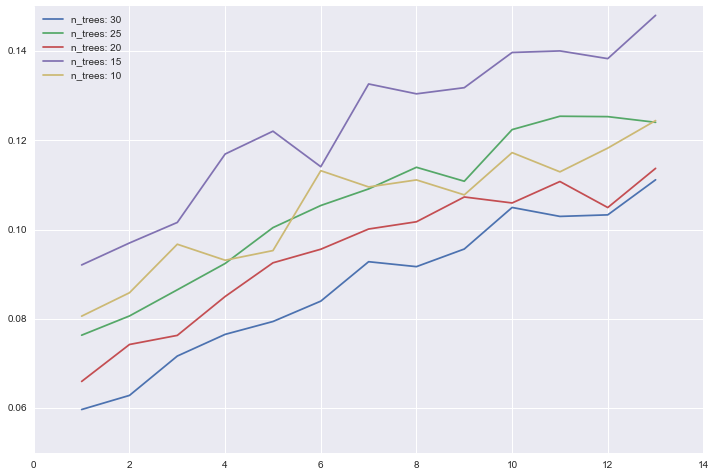

In [106]:
feature_30 = np.mean(np.mean(f1_13_30, axis=2), axis=1)
feature_25 = np.mean(np.mean(f1_13_25, axis=2), axis=1)
feature_20 = np.mean(np.mean(f1_13_20, axis=2), axis=1)
feature_15 = np.mean(np.mean(f1_13_15, axis=2), axis=1)
feature_10 = np.mean(np.mean(f1_13_10, axis=2), axis=1)

plt.figure(figsize=[12,8])
plt.plot(param_choice, feature_30, label="n_trees: 30")
plt.plot(param_choice, feature_25, label="n_trees: 25")
plt.plot(param_choice, feature_20, label="n_trees: 20")
plt.plot(param_choice, feature_15, label="n_trees: 15")
plt.plot(param_choice, feature_10, label="n_trees: 10")
plt.legend(loc="upper left")

#### With numerical

1. F-score

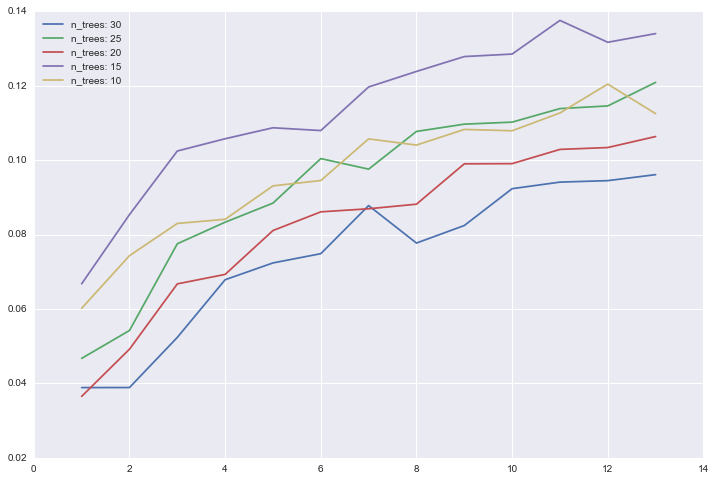

In [184]:
param_choice = np.linspace(1,13,13)
f1_13_30 = tune_feature(X_all_rf, Y_all, score="f1", param_choice=param_choice, n_trees=30)
f1_13_25 = tune_feature(X_all_rf, Y_all, score="f1", param_choice=param_choice, n_trees=25)
f1_13_20 = tune_feature(X_all_rf, Y_all, score="f1", param_choice=param_choice, n_trees=20)
f1_13_15 = tune_feature(X_all_rf, Y_all, score="f1", param_choice=param_choice, n_trees=15)
f1_13_10 = tune_feature(X_all_rf, Y_all, score="f1", param_choice=param_choice, n_trees=10)

feature_30 = np.mean(np.mean(f1_13_30, axis=2), axis=1)
feature_25 = np.mean(np.mean(f1_13_25, axis=2), axis=1)
feature_20 = np.mean(np.mean(f1_13_20, axis=2), axis=1)
feature_15 = np.mean(np.mean(f1_13_15, axis=2), axis=1)
feature_10 = np.mean(np.mean(f1_13_10, axis=2), axis=1)

plt.figure(figsize=[12,8])
plt.plot(param_choice, feature_30, label="n_trees: 30")
plt.plot(param_choice, feature_25, label="n_trees: 25")
plt.plot(param_choice, feature_20, label="n_trees: 20")
plt.plot(param_choice, feature_15, label="n_trees: 15")
plt.plot(param_choice, feature_10, label="n_trees: 10")
plt.legend(loc="upper left")

2. Precision

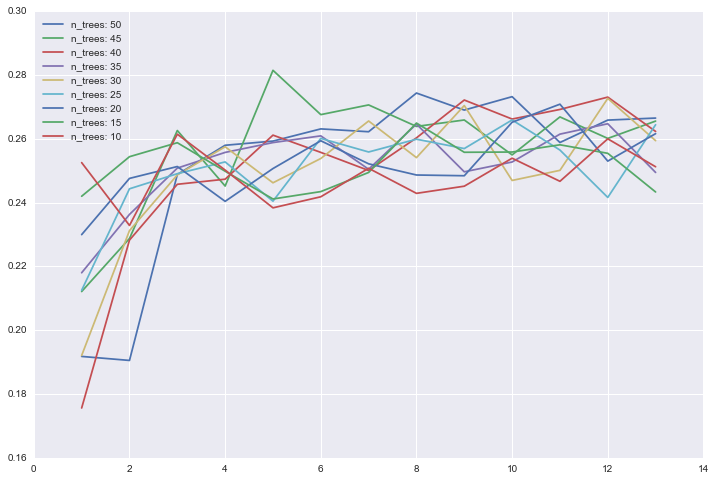

In [186]:
param_choice = np.linspace(1,13,13)
precision_13_50 = tune_feature(X_all_rf, Y_all, score="precision", param_choice=param_choice, n_trees=50, n_run=100)
precision_13_45 = tune_feature(X_all_rf, Y_all, score="precision", param_choice=param_choice, n_trees=45, n_run=100)
precision_13_40 = tune_feature(X_all_rf, Y_all, score="precision", param_choice=param_choice, n_trees=40, n_run=100)
precision_13_35 = tune_feature(X_all_rf, Y_all, score="precision", param_choice=param_choice, n_trees=35, n_run=100)
precision_13_30 = tune_feature(X_all_rf, Y_all, score="precision", param_choice=param_choice, n_trees=30, n_run=100)
precision_13_25 = tune_feature(X_all_rf, Y_all, score="precision", param_choice=param_choice, n_trees=25, n_run=100)
precision_13_20 = tune_feature(X_all_rf, Y_all, score="precision", param_choice=param_choice, n_trees=20, n_run=100)
precision_13_15 = tune_feature(X_all_rf, Y_all, score="precision", param_choice=param_choice, n_trees=15, n_run=100)
precision_13_10 = tune_feature(X_all_rf, Y_all, score="precision", param_choice=param_choice, n_trees=10, n_run=100)

feature_50 = np.mean(np.mean(precision_13_50, axis=2), axis=1)
feature_45 = np.mean(np.mean(precision_13_45, axis=2), axis=1)
feature_40 = np.mean(np.mean(precision_13_40, axis=2), axis=1)
feature_35 = np.mean(np.mean(precision_13_35, axis=2), axis=1)
feature_30 = np.mean(np.mean(precision_13_30, axis=2), axis=1)
feature_25 = np.mean(np.mean(precision_13_25, axis=2), axis=1)
feature_20 = np.mean(np.mean(precision_13_20, axis=2), axis=1)
feature_15 = np.mean(np.mean(precision_13_15, axis=2), axis=1)
feature_10 = np.mean(np.mean(precision_13_10, axis=2), axis=1)

plt.figure(figsize=[12,8])
plt.plot(param_choice, feature_50, label="n_trees: 50")
plt.plot(param_choice, feature_45, label="n_trees: 45")
plt.plot(param_choice, feature_40, label="n_trees: 40")
plt.plot(param_choice, feature_35, label="n_trees: 35")
plt.plot(param_choice, feature_30, label="n_trees: 30")
plt.plot(param_choice, feature_25, label="n_trees: 25")
plt.plot(param_choice, feature_20, label="n_trees: 20")
plt.plot(param_choice, feature_15, label="n_trees: 15")
plt.plot(param_choice, feature_10, label="n_trees: 10")
plt.legend(loc="upper left")

3. Recall

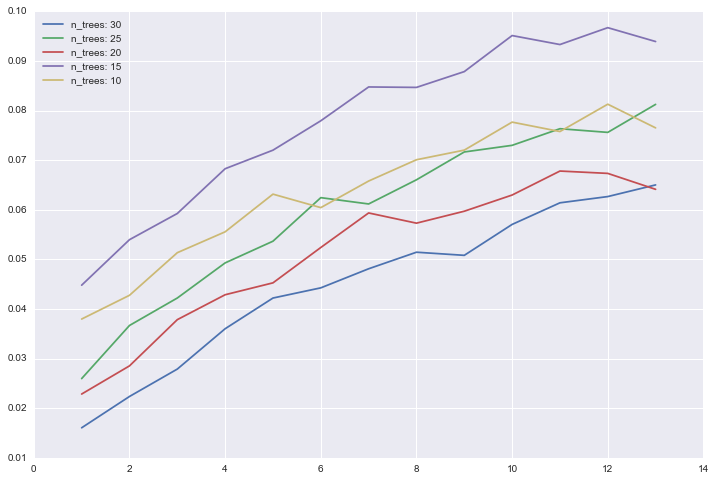

In [187]:
param_choice = np.linspace(1,13,13)
recall_13_30 = tune_feature(X_all_rf, Y_all, score="recall", param_choice=param_choice, n_trees=30)
recall_13_25 = tune_feature(X_all_rf, Y_all, score="recall", param_choice=param_choice, n_trees=25)
recall_13_20 = tune_feature(X_all_rf, Y_all, score="recall", param_choice=param_choice, n_trees=20)
recall_13_15 = tune_feature(X_all_rf, Y_all, score="recall", param_choice=param_choice, n_trees=15)
recall_13_10 = tune_feature(X_all_rf, Y_all, score="recall", param_choice=param_choice, n_trees=10)

feature_30 = np.mean(np.mean(recall_13_30, axis=2), axis=1)
feature_25 = np.mean(np.mean(recall_13_25, axis=2), axis=1)
feature_20 = np.mean(np.mean(recall_13_20, axis=2), axis=1)
feature_15 = np.mean(np.mean(recall_13_15, axis=2), axis=1)
feature_10 = np.mean(np.mean(recall_13_10, axis=2), axis=1)

plt.figure(figsize=[12,8])
plt.plot(param_choice, feature_30, label="n_trees: 30")
plt.plot(param_choice, feature_25, label="n_trees: 25")
plt.plot(param_choice, feature_20, label="n_trees: 20")
plt.plot(param_choice, feature_15, label="n_trees: 15")
plt.plot(param_choice, feature_10, label="n_trees: 10")
plt.legend(loc="upper left")

### 3.2 Find the right number of trees to put into to random forest

In [289]:
def tune_tree(X_rf, y, score, param_choice, n_run=50, fold=3):
    param_scores = []
    for n in param_choice:
        cv_scores_all_run = []
        clf_rf = RandomForestClassifier(n_estimators=int(n), 
                                max_features=13, 
                                max_depth=None,
                                min_samples_split=1,
                                n_jobs=-1,
                                warm_start=True,
                                class_weight = "balanced")
        for i in range(n_run):       
            cv_score = cross_val_score(clf_rf, X_rf, y, scoring=score, cv=fold)
            cv_scores_all_run.append(cv_score)
        
        param_scores.append(cv_scores_all_run)
    return param_scores

In [285]:
param_tree = np.linspace(10,500,50)
tree_f1 = tune_tree(X_all_rf, Y_all, score="f1", param_choice=param_tree, n_run=100, fold=3)
tree_precision = tune_tree(X_all_rf, Y_all, score="precision", param_choice=param_tree, n_run=100, fold=3)
tree_recall = tune_tree(X_all_rf, Y_all, score="recall", param_choice=param_tree, n_run=100, fold=3)

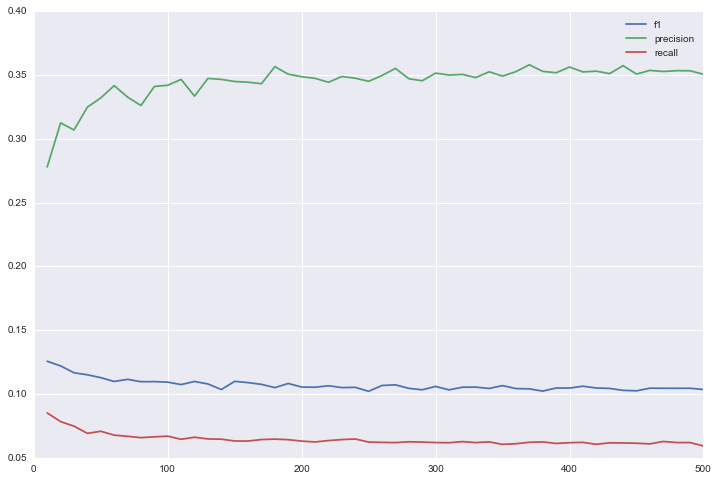

In [286]:
plt.figure(figsize=[12,8])
f1_tree = np.mean(np.mean(tree_f1, axis=2), axis=1)
precision_tree = np.mean(np.mean(tree_precision, axis=2), axis=1)
recall_tree = np.mean(np.mean(tree_recall, axis=2), axis=1)
plt.plot(param_tree, f1_tree, label="f1")
plt.plot(param_tree, precision_tree, label="precision")
plt.plot(param_tree, recall_tree, label="recall")
plt.legend()

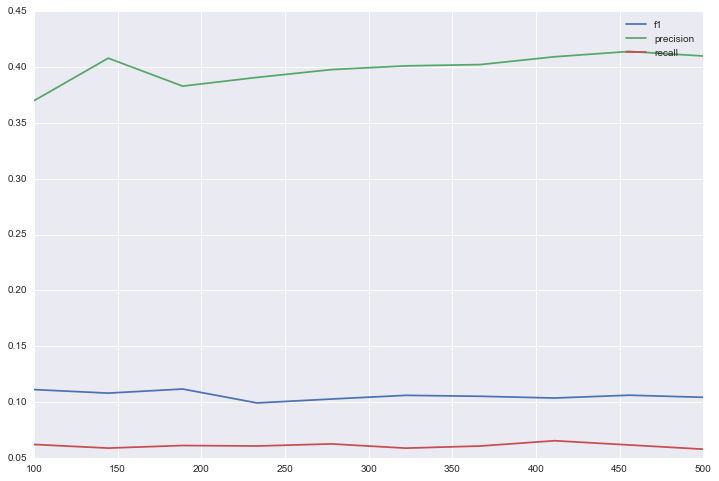

In [290]:
param_tree2 = np.linspace(100,500,10)
tree_f12 = tune_tree(X_all_rf, Y_all, score="f1", param_choice=param_tree2, n_run=10, fold=3)
tree_precision2 = tune_tree(X_all_rf, Y_all, score="precision", param_choice=param_tree2, n_run=10, fold=3)
tree_recall2 = tune_tree(X_all_rf, Y_all, score="recall", param_choice=param_tree2, n_run=10, fold=3)
plt.figure(figsize=[12,8])
f1_tree2 = np.mean(np.mean(tree_f12, axis=2), axis=1)
precision_tree2 = np.mean(np.mean(tree_precision2, axis=2), axis=1)
recall_tree2 = np.mean(np.mean(tree_recall2, axis=2), axis=1)
plt.plot(param_tree2, f1_tree2, label="f1")
plt.plot(param_tree2, precision_tree2, label="precision")
plt.plot(param_tree2, recall_tree2, label="recall")
plt.legend()

### 3.3 Find the right threashold to increase F score:

In [ ]:
def tune_threshold(X_rf, y, score, param_choice, n_run=50, fold=3):
    param_scores = []
    for n in param_choice:
        cv_scores_all_run = []
        clf_rf = RandomForestClassifier(n_estimators=100, 
                                max_features=13, 
                                max_depth=None,
                                min_samples_split=1,
                                n_jobs=-1,
                                warm_start=True,
                                class_weight = "balanced")
        for i in range(n_run):       
            cv_score = cross_val_predict(clf_rf, X_rf, y, scoring=score, cv=fold)
            cv_scores_all_run.append(cv_score)
        
        param_scores.append(cv_scores_all_run)
    return param_scores

In [305]:
class proba_logreg(LogisticRegression):
    def predict(self, X):
        return LogisticRegression.predict_proba(self, X)[:,1]

# cross validation probabilities
probas = cross_val_predict(proba_logreg(), X_all_rf, Y_all, cv=3)

In [306]:
probas

array([ 0.19033727,  0.1428385 ,  0.18481   , ...,  0.23743276,
        0.31376714,  0.31708158])

In [323]:
class rf_proba(RandomForestClassifier):
    
    def predict(self, X):

        return RandomForestClassifier.predict_proba(self, X)

rf_probas = cross_val_predict(rf_proba(n_estimators=200, 
                        max_features=13, 
                        max_depth=None,
                        min_samples_split=1,
                        n_jobs=-1,
                        warm_start=True,
                        class_weight = "balanced"), X_all_rf, Y_all, cv=3)

In [331]:
threshold = 0.3
rf_predict = rf_probas[:,1] >= [threshold]*len(rf_probas)

prfs = np.array(metrics.precision_recall_fscore_support(Y_all, rf_predict))

In [332]:
prfs[:-1,1]

array([ 0.29045643,  0.33175355,  0.30973451])

In [346]:
thresholds = np.linspace(0.1, 0.9, 17)
n_run=100

pre_all = []
rec_all = []
f_all = []
for threshold in thresholds:
    pre_list = []
    rec_list = []
    f_list = []
    for i in range(n_run):
        rf_probas = cross_val_predict(rf_proba(n_estimators=150, 
                            max_features=13, 
                            max_depth=None,
                            min_samples_split=1,
                            n_jobs=-1,
                            warm_start=True,
                            class_weight = "balanced"), X_all_rf, Y_all, cv=3)

        rf_predict = rf_probas[:,1] >= [threshold]*len(rf_probas)
        pre,rec,f = np.array(metrics.precision_recall_fscore_support(Y_all, rf_predict))[:-1,1]
        pre_list.append(pre)
        rec_list.append(rec)
        f_list.append(f)
    pre_all.append(pre_list)
    rec_all.append(rec_list)
    f_all.append(f_list)

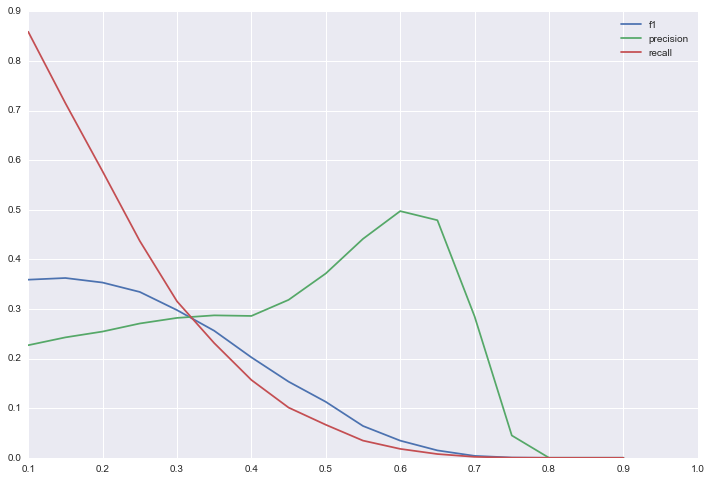

In [347]:
pre_threshold = np.mean(pre_all, axis=1)
rec_threshold = np.mean(rec_all, axis=1)
f_threshold = np.mean(f_all, axis=1)
plt.figure(figsize=(12,8))
plt.plot(thresholds, f_threshold, label="f1")
plt.plot(thresholds, pre_threshold, label="precision")
plt.plot(thresholds, rec_threshold, label="recall")
plt.legend()

In [338]:
thresholds

array([ 0.1       ,  0.14444444,  0.18888889,  0.23333333,  0.27777778,
        0.32222222,  0.36666667,  0.41111111,  0.45555556,  0.5       ,
        0.54444444,  0.58888889,  0.63333333,  0.67777778,  0.72222222,
        0.76666667,  0.81111111,  0.85555556,  0.9       ])

In [ ]:
threshold = 0.6
param_tree = np.linspace(50,500,10)
n_run=100

pre_all = []
rec_all = []
f_all = []

for n_tree in param_tree:
    pre_list = []
    rec_list = []
    f_list = []
    for i in range(n_run):
        rf_probas = cross_val_predict(rf_proba(n_estimators=int(n_tree), 
                            max_features=13, 
                            max_depth=None,
                            min_samples_split=1,
                            n_jobs=-1,
                            warm_start=True,
                            class_weight = "balanced"), X_all_rf, Y_all, cv=3)

        rf_predict = rf_probas[:,1] >= [threshold]*len(rf_probas)
        pre,rec,f = np.array(metrics.precision_recall_fscore_support(Y_all, rf_predict))[:-1,1]
        pre_list.append(pre)
        rec_list.append(rec)
        f_list.append(f)
    pre_all.append(pre_list)
    rec_all.append(rec_list)
    f_all.append(f_list)


In [ ]:
pre_tree = np.mean(pre_all, axis=1)
rec_tree = np.mean(rec_all, axis=1)
f_tree = np.mean(f_all, axis=1)
plt.figure(figsize=(12,8))
plt.plot(param_tree, f_tree, label="f1")
plt.plot(param_tree, pre_tree, label="precision")
plt.plot(param_tree, rec_tree, label="recall")
plt.legend()

### NOW, THE REAL MEAT

In [388]:
class rf_proba(RandomForestClassifier):
    def predict(self, X):
        return RandomForestClassifier.predict_proba(self, X)

# cross validation probabilities
# probas = cross_val_predict(proba_logreg(), X_all_rf, Y_all, cv=3)

In [395]:
def predict_willingness(X_rf, X_lr, y, param_rf, param_lr, label_dict, threshold = 0.6, fold=3):
    
    # Fit logistic
    clf_lr = LogisticRegression()
    clf_lr.fit(X_lr, y)
    label_lr = [label_dict[param] for param in param_lr]
    coef_sign = dict(zip(param_lr, ["(-)" if coef<0 else "(+)" for coef in np.sign(np.ravel(clf_lr.coef_))]))
    
    # Fit random forest
    clf_rf = RandomForestClassifier(n_estimators=300, 
                        max_features=13, 
                        max_depth=None,
                        min_samples_split=1,
                        n_jobs=-1,
                        warm_start=True,
                        class_weight = "balanced")
    clf_rf.fit(X_rf, y)
    label_rf = [label_dict[param] for param in param_rf]
    
    # Show precision, recall and f-score
    rf_probas = cross_val_predict(rf_proba(n_estimators=300, 
                    max_features=13, 
                    max_depth=None,
                    min_samples_split=1,
                    n_jobs=-1,
                    warm_start=True,
                    class_weight = "balanced"), X_rf, y, cv=3)
    rf_predict = rf_probas[:,1] >= [threshold]*len(rf_probas)
    print rf_predict
    pre,rec,f,sup = np.array(metrics.precision_recall_fscore_support(y, rf_predict))[:,1]
    print "precision: ", pre
    print "recall: ", rec
    print "f-score: ", f
    print "precdicted positive: ", np.sum(rf_predict)
    print "actual positive: ", np.sum(y)
    
    # Plot feature importance from random forest
    importances = clf_rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
    indices = np.argsort(importances)[::1]
    param_label = [label_rf[ind] + coef_sign[param_rf[ind]] for ind in indices]

    # Plot the feature importances of the forest
    plt.figure(figsize=(16,10))
    plt.title("Feature Importance", fontsize=30)
    plt.barh(range(X_rf.shape[1]), importances[indices], xerr=std[indices], color=["orange"], align="center")
    plt.yticks(range(X_rf.shape[1]), param_label,  fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylim([-1, X_rf.shape[1]])
    # plt.xlim([0,0.25])
    plt.grid(False)
    plt.show()
    
    return pre, rec, f, sup, clf_rf, clf_lr

[False False False ..., False False False]

precision:  0.571428571429
recall:  0.0189573459716
f-score:  0.0366972477064
precdicted positive:  7
actual positive:  211.0


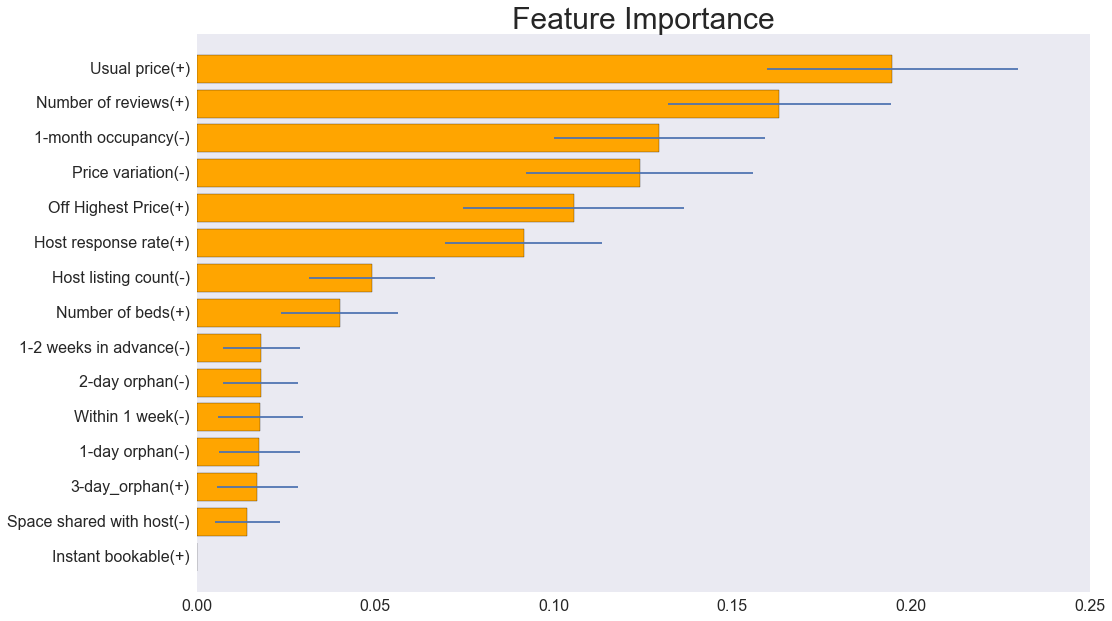

In [396]:
pre, rec, f, sup, clf_rf, clf_lr = predict_willingness(X_all_rf, X_all_lr, Y_all, param_rf = param_rf, param_lr = param_lr, label_dict = label_dict)

In [280]:
from sklearn.externals import joblib

clf_rf = RandomForestClassifier(n_estimators=1000, 
                        max_features=int(np.sqrt(X_all_rf.shape[1])), 
                        max_depth=None,
                        min_samples_split=1)

clf_rf.fit(X_all_rf,Y_all)

# now you can save it to a file
joblib.dump(clf_rf, 'clf_all_rf.pkl') 
# and later you can load it
clf = joblib.load('clf_all_rf.pkl')

Y_test = clf.predict(X_all_rf[50])
print Y_test

[ 0.]


/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [34]:
import pickle
# now you can save it to a file
with open('filename.pkl', 'wb') as f:
    pickle.dump(clf_rf, f)

# and later you can load it
with open('filename.pkl', 'rb') as f:
    clf = pickle.load(f)

In [424]:
def predict_discount(X_rf, X_lr, y, param_rf, param_lr, label_dict, fold=3):
    
    # Fit logistic
    clf_lr = LinearRegression()
    clf_lr.fit(X_lr, y)
    label_lr = [label_dict[param] for param in param_lr]
    coef_sign = dict(zip(param_lr, ["(-)" if coef<0 else "(+)" for coef in np.sign(np.ravel(clf_lr.coef_))]))
    
    # Fit random forest
    clf_rf = RandomForestRegressor(n_estimators=100, 
                        max_features=13, 
                        max_depth=None,
                        min_samples_split=1,
                        n_jobs=-1,
                        warm_start=True)
    clf_rf.fit(X_rf, y)
    label_rf = [label_dict[param] for param in param_rf]
    
    # Show precision, recall and f-score
    rf_predict = cross_val_predict(clf_rf, X_rf, y, cv=fold, n_jobs=-1)
        
#     print zip(y, rf_predict)

    r2 = metrics.r2_score(y, rf_predict)
    print "r2: ", r2

    # Plot feature importance from random forest
    importances = clf_rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
    indices = np.argsort(importances)[::1]
    param_label = [label_rf[ind] + coef_sign[param_rf[ind]] for ind in indices]

    # Plot the feature importances of the forest
    plt.figure(figsize=(16,10))
    plt.title("Feature Importance", fontsize=30)
    plt.barh(range(X_rf.shape[1]), importances[indices], xerr=std[indices], color=["orange"], align="center")
    plt.yticks(range(X_rf.shape[1]), param_label,  fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylim([-1, X_rf.shape[1]])
    # plt.xlim([0,0.25])
    plt.grid(False)
    plt.show()
    
    return r2, clf_rf, clf_lr

r2:  0.05957973561


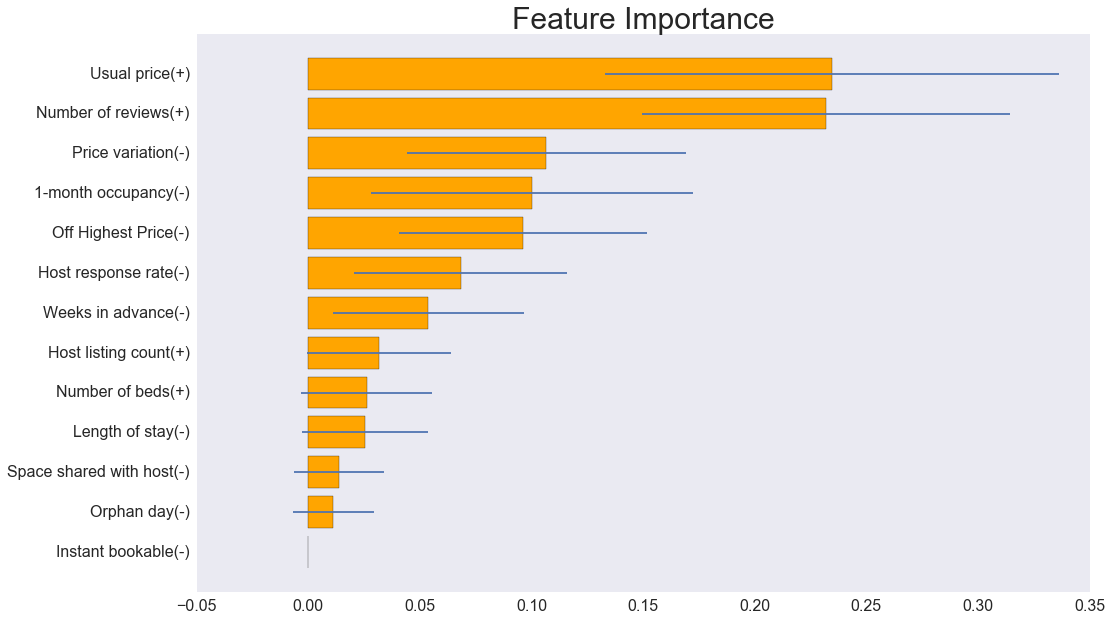

In [425]:
r2, clf_rf, clf_lr = predict_discount(X_discount_rf, X_discount_lr, Y_discount, param_rf = param_rf, param_lr = param_lr, label_dict = label_dict)

In [ ]:
param_tree = np.linspace(10,500,50)
n_run = 100
r2_all = []
for n_tree in param_tree:
    r2_list = []
    for i in range(n_run):
        clf_rf = RandomForestRegressor(n_estimators=int(n_tree), 
                            max_features=13, 
                            max_depth=None,
                            min_samples_split=1,
                            n_jobs=-1,
                            warm_start=True)

        rf_predict = cross_val_predict(clf_rf, X_discount_rf, Y_discount, cv=3, n_jobs=-1)
        r2 = metrics.r2_score(Y_discount, rf_predict)
        r2_list.append(r2)
    r2_all.append(r2)
 
r2_tree = np.mean(f_all, axis=1)
plt.figure(figsize=(12,8))
plt.plot(param_tree, r2_tree, label="r2")
plt.legend()

In [25]:
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(max_depth=None, n_estimators=1000, max_features=5),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

print "Average Cross Validation F-Score:"
for name, clf in zip(names, classifiers):
    clf.fit(X_all_rf, Y_all)
    cv_scores = cross_val_score(clf, X_all_rf, Y_all, scoring='f1', cv=5)

    print "%s: "%name, np.mean(cv_scores)

Average Cross Validation F-Score:
Nearest Neighbors:  0.244395957155
Linear SVM:  0.0
RBF SVM:  0.0254032258065
Decision Tree:  0.306400558385
Random Forest:  0.0663663663664
AdaBoost:  0.0995816842256
Naive Bayes:  0.270103071933
Linear Discriminant Analysis:  0.0
Quadratic Discriminant Analysis:  0.327434760216
